In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'full.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'ogbl-collab', 'storage_dir': '../data/', 'embedding_config': './full_embedding.json', 'train_ratio': 0.3, 'hidden_dim': 128, 'max_hops': 4, 'num_threads': 16, 'max_epochs': 10, 'batch_size': 128, 'dim_feedforward': 128, 'nhead': 4, 'num_layers': 3, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 0.5, 'embedding': 'all'}


In [4]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 855944 edges in train split...


Scanning edges: 100%|██████████| 855944/855944 [00:04<00:00, 185781.66it/s]



Pre-scan Results for train:
  Total edges scanned: 855944
  Valid edges (has pos & neg paths): 261580 (30.6%)
  Missing positive paths: 594364 (69.4%)
  Missing negative paths: 594364 (69.4%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 261580 valid edges.
  New edge count for train: 261580
--- Pre-scan complete ---

Use shallow embeddings: True at config ./full_embedding.json
Loading KGE model proxy for train split from ../data/transe_ogbl-collab_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_ogbl-collab_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 261580 edges for train split.
Setting up data for split: valid
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./full_embedding.json
Loading KGE model proxy for valid split from ../data/transe_ogbl-collab_all_config.json
KGEModelProxy initialized on

In [13]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'test'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'test' split...


In [14]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        plot_data.append({
            'path_length': pos_path_len,
            'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link'
        })

    # Process negative paths
    if eid_str in neg_paths:
        for neg_path_interleaved in neg_paths[eid_str]:
            # As per loader.py, nodes are at even indices
            neg_path_len = len(neg_path_interleaved[::2])
            plot_data.append({
                'path_length': neg_path_len,
                'path_type': 'negative',
                'label': 'true_link' if label == 1 else 'false_link'
            })


Extracting paths: 100%|██████████| 146329/146329 [00:05<00:00, 25663.69it/s]


In [15]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


Generating plots...


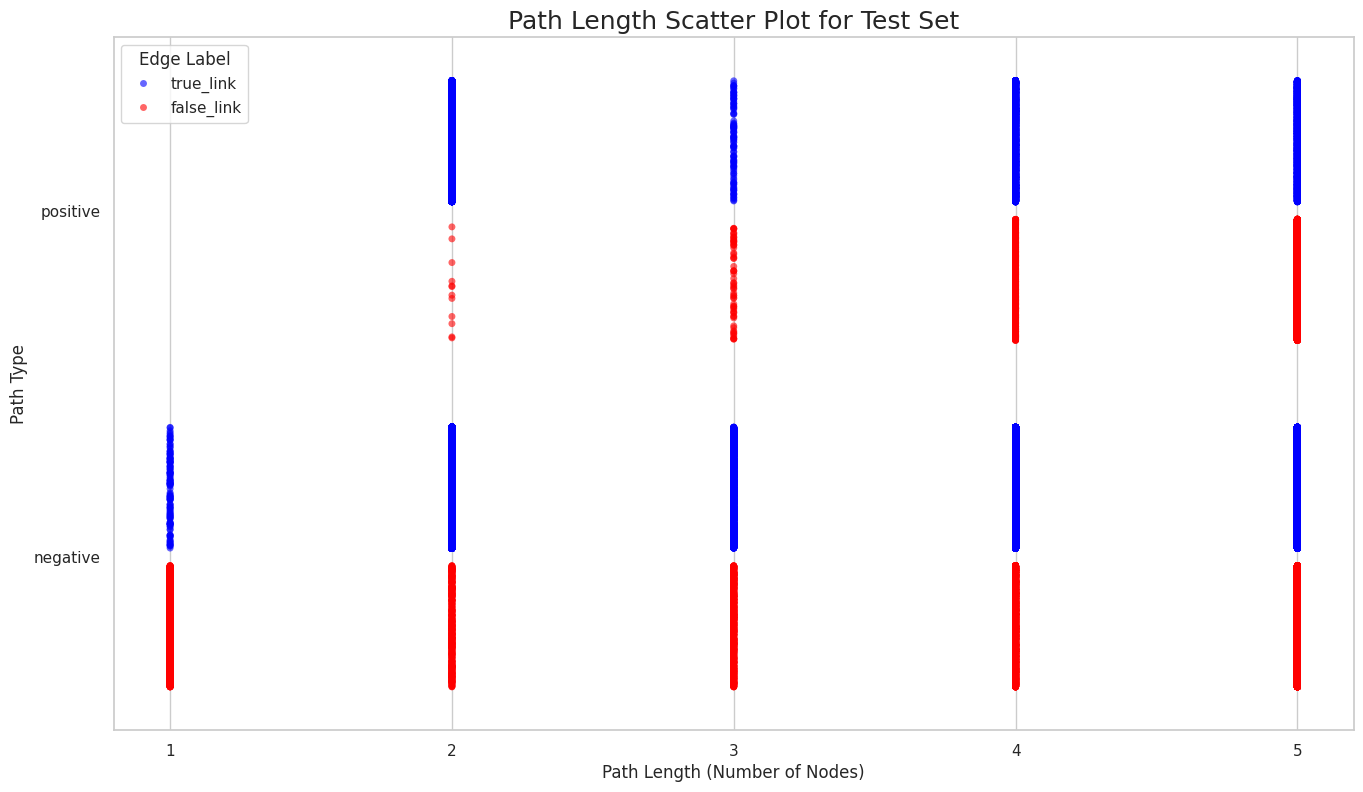

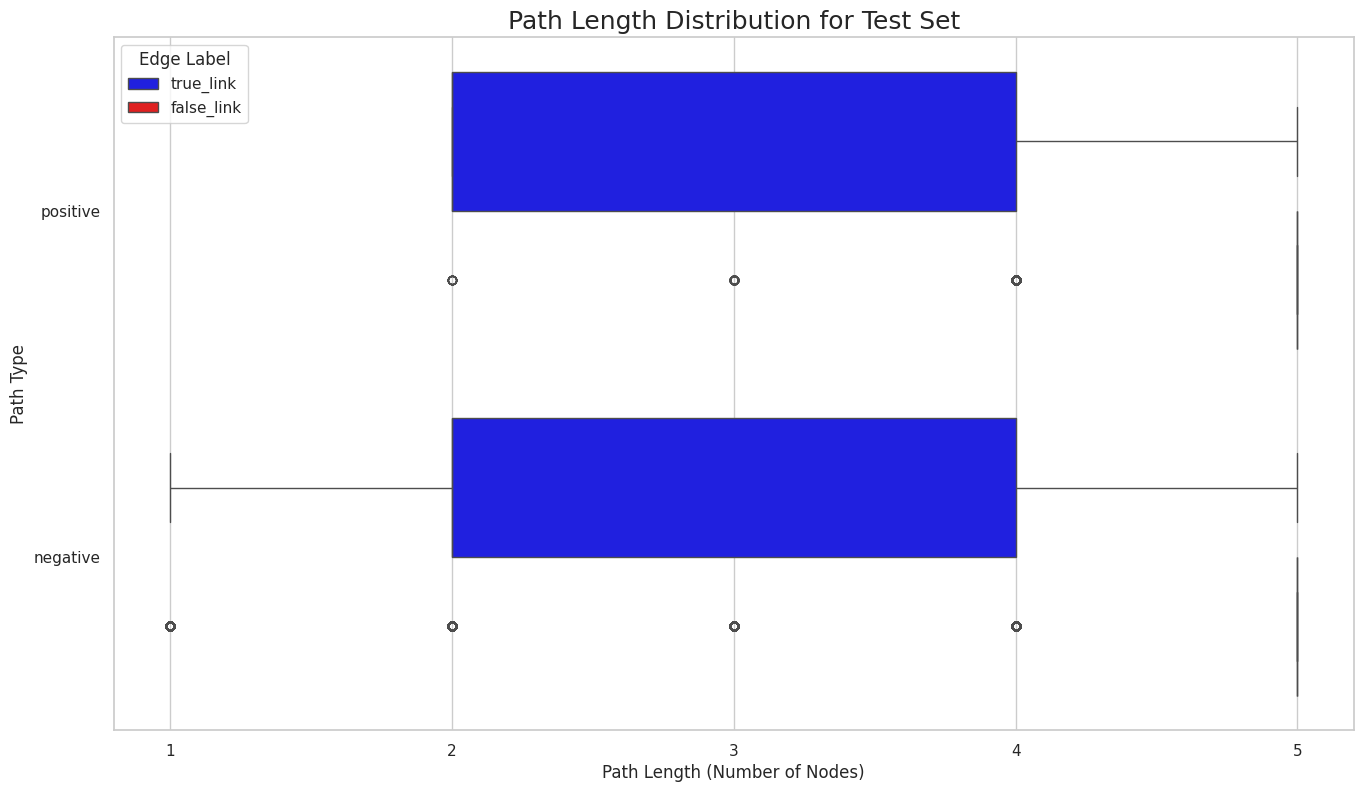

In [16]:

# --- 3. Visualization ---
if not plot_df.empty:
    print("Generating plots...")
    # Set plot style
    sns.set_theme(style="whitegrid")

    # Create a scatter plot (strip plot) to show the distribution
    plt.figure(figsize=(16, 9))
    sns.stripplot(data=plot_df, x='path_length', y='path_type', hue='label',
                  jitter=0.35, alpha=0.6, dodge=True, palette={'true_link': 'blue', 'false_link': 'red'})
    plt.title(
        f'Path Length Scatter Plot for {split.capitalize()} Set', fontsize=18)
    plt.xlabel('Path Length (Number of Nodes)', fontsize=12)
    plt.ylabel('Path Type', fontsize=12)
    plt.xticks(range(plot_df['path_length'].min(),
               plot_df['path_length'].max() + 1))
    plt.legend(title='Edge Label')
    plt.show()

    # Create a box plot for a clearer summary of the distributions
    plt.figure(figsize=(16, 9))
    sns.boxplot(data=plot_df, x='path_length', y='path_type', hue='label',
                palette={'true_link': 'blue', 'false_link': 'red'})
    plt.title(
        f'Path Length Distribution for {split.capitalize()} Set', fontsize=18)
    plt.xlabel('Path Length (Number of Nodes)', fontsize=12)
    plt.ylabel('Path Type', fontsize=12)
    plt.xticks(range(plot_df['path_length'].min(),
               plot_df['path_length'].max() + 1))
    plt.legend(title='Edge Label')
    plt.show()
else:
    print("No data available to plot.")

In [17]:
plot_df

,path_length,path_type,label
0,5,positive,true_link
1,5,negative,true_link
2,5,negative,true_link
3,5,negative,true_link
4,5,negative,true_link
...,...,...,...
872624,5,negative,false_link
872625,5,positive,false_link
872626,1,negative,false_link
872627,4,positive,false_link


In [18]:
pos_df = plot_df[plot_df['path_type'] == 'positive'].copy()
pos_df

,path_length,path_type,label
0,5,positive,true_link
21,2,positive,true_link
42,4,positive,true_link
63,2,positive,true_link
84,2,positive,true_link
...,...,...,...
872590,5,positive,false_link
872592,5,positive,false_link
872613,5,positive,false_link
872625,5,positive,false_link


In [19]:
pos_df[pos_df["label"] == "true_link"].groupby("path_length").count()

,path_type,label
path_length,,
2,21538,21538
3,107,107
4,12911,12911
5,3696,3696


In [20]:
pos_df[pos_df["label"] == "false_link"].groupby("path_length").count()

,path_type,label
path_length,,
2,12,12
3,63,63
4,929,929
5,9707,9707


In [21]:
plot_df[plot_df["path_length"] < 2]

,path_length,path_type,label
9205,1,negative,true_link
10566,1,negative,true_link
10589,1,negative,true_link
11739,1,negative,true_link
22133,1,negative,true_link
...,...,...,...
872336,1,negative,false_link
872380,1,negative,false_link
872403,1,negative,false_link
872484,1,negative,false_link


In [24]:
plot_df[plot_df["path_length"] < 2].describe()

,path_length
count,2242.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [25]:
pos_df.describe()

,path_length
count,48963.000000
mean,3.390009
std,1.290607
min,2.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [23]:
1 - 12/50

0.76